# Imports

In [1]:
# Ignore warnings from UMAP
import warnings
warnings.filterwarnings('ignore')

# GPU Info

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 16 00:38:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!mkdir /content/dataset

In [5]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Hyperparameters Setup

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 100
NUM_CLASSES = 2
CLASSES = ["Normal", "Stroke"]

In [7]:
import keras 
import tensorflow as tf

LOSS = tf.keras.losses.BinaryCrossentropy() # Not un-weighted 
METRICS = [
      keras.metrics.CategoricalAccuracy(name="accuracy"),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

# Dataset Setup

In [8]:
import os

DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

path, dirs, files = next(os.walk(DF_TRAIN + "/Stroke"))
file_count = len(files)
print('Stroke:', file_count)
path, dirs, files = next(os.walk(DF_TRAIN + "/Normal"))
file_count = len(files)
print('Non-Stroke:', file_count)

Stroke: 825
Non-Stroke: 1426


In [72]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(validation_split = 0.2)
                              #  rotation_range = 0.2)
test_gen  = ImageDataGenerator()

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                          )

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                          )

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                         )

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


# Show Image Samples

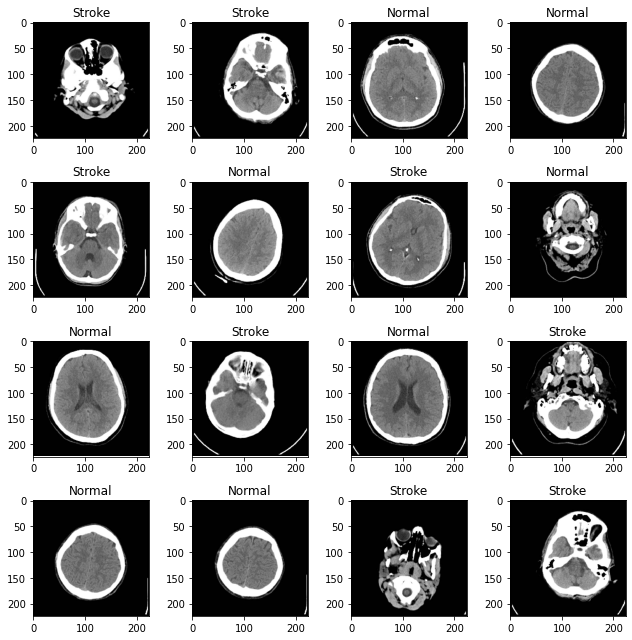

In [10]:
# show images from dataset
import matplotlib.pyplot as plt

images, labels = next(test_set)
labels = labels.argmax(axis=1)
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.astype("uint8"))
    ax.set_title(CLASSES[label.astype(int)])
plt.tight_layout()
plt.show()

# Experiments

## Auxiliar Functions

**Training**

In [11]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

In [12]:
def plot_training_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

**Predict**

In [13]:
def get_classes(data_set):
  f_classes = []
  idx_class = data_set.index_array
  for idc in idx_class:
    f_classes.append(data_set.classes[idc])
  return f_classes

**Plot manifolds**

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def print2D(embedding, title):
  fig = plt.figure(figsize=[25,10])
  plt.scatter(
      embedding[:, 0],
      embedding[:, 1])
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(title, fontsize=24)
  plt.show()

def print3D(embedding, title, classes):
  fig = plt.figure(figsize=[25,10])
  ax = plt.axes(projection ="3d")
  p = ax.scatter(
      embedding[:, 0],
      embedding[:, 1],
      embedding[:, 2],
      c = classes 
  )
  plt.title(title, fontsize=24)
  fig.colorbar(p,boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
  plt.show()

**UMAP**

In [ ]:
!pip install umap-learn[plot]

     |████████████████████████████████| 86 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 8.4 MB/s 
     |████████████████████████████████| 15.8 MB 73.4 MB/s 
     |████████████████████████████████| 76 kB 6.4 MB/s 
     |████████████████████████████████| 802 kB 45.2 MB/s 
     |████████████████████████████████| 132 kB 71.6 MB/s 
     |████████████████████████████████| 802 kB 60.2 MB/s 
     |████████████████████████████████| 793 kB 70.0 MB/s 
     |████████████████████████████████| 793 kB 64.8 MB/s 
     |████████████████████████████████| 791 kB 67.2 MB/s 
     |████████████████████████████████| 786 kB 64.7 MB/s 
     |████████████████████████████████| 779 kB 66.0 MB/s 
     |████████████████████████████████| 778 kB 64.3 MB/s 
     |████████████████████████████████| 776 kB 63.3 MB/s 
     |████████████████████████████████| 769 kB 64.3 MB/s 
     |████████████████████████████████| 766 kB 29.5 MB/s 
     |████████████████████████████████| 1.0 MB 103.3 MB/s 
     |███████████

In [ ]:
import umap

def uMAP(model, dataset, feature=True):
  embeddingUMAP = umap.UMAP(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 3
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresUMAP = embeddingUMAP.fit_transform(Y_pred)
  return featuresUMAP

## EfficientNetB4

### Build Model

In [ ]:
# create EfficientNetB4 base model
base_model = tf.keras.applications.EfficientNetB4(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')                                                                   
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=.2, seed = 123)(x)        
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid', name = 'Final')(x)
model_effnet = tf.keras.models.Model(name = "efficientnetb4", inputs = base_model.input, outputs = predictions)

model_effnet.compile(
    optimizer = OPTIMIZER,
    loss = LOSS,
    metrics = METRICS,
)

71696384/71686520 [==============================] - 2s 0us/step


In [ ]:
model_effnet.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [ ]:
# model_effnet.load_weights('/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.efficientnetb4.h5')

### Train Model

In [ ]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb4')
history_eff = model_effnet.fit(train_set,
                               epochs = 2,
                               validation_data = valid_set,
                               callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-14 03:15:57.053086
Epoch 1/2
113/113 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.7468 - tp: 1349.0000 - fp: 462.0000 - tn: 1339.0000 - fn: 452.0000 - BinaryAccuracy: 0.7463 - precision: 0.7449 - recall: 0.7490 - auc: 0.8254
Epoch 00001: val_loss improved from inf to 1.33859, saving model to model.efficientnetb4.h5
113/113 [==============================] - 67s 372ms/step - loss: 0.5166 - accuracy: 0.7468 - tp: 1349.0000 - fp: 462.0000 - tn: 1339.0000 - fn: 452.0000 - BinaryAccuracy: 0.7463 - precision: 0.7449 - recall: 0.7490 - auc: 0.8254 - val_loss: 1.3386 - val_accuracy: 0.7444 - val_tp: 337.0000 - val_fp: 115.0000 - val_tn: 335.0000 - val_fn: 113.0000 - val_BinaryAccuracy: 0.7467 - val_precision: 0.7456 - val_recall: 0.7489 - val_auc: 0.7546 - lr: 0.0010
Epoch 2/2
113/113 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.8423 - tp: 1521.0000 - fp: 283.0000 - tn: 1518.0000 - fn: 280.0000 - BinaryAccuracy: 0.8437 - precision: 

In [ ]:
!cp '/content/model.efficientnetb4.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.efficientnetb4.h5'

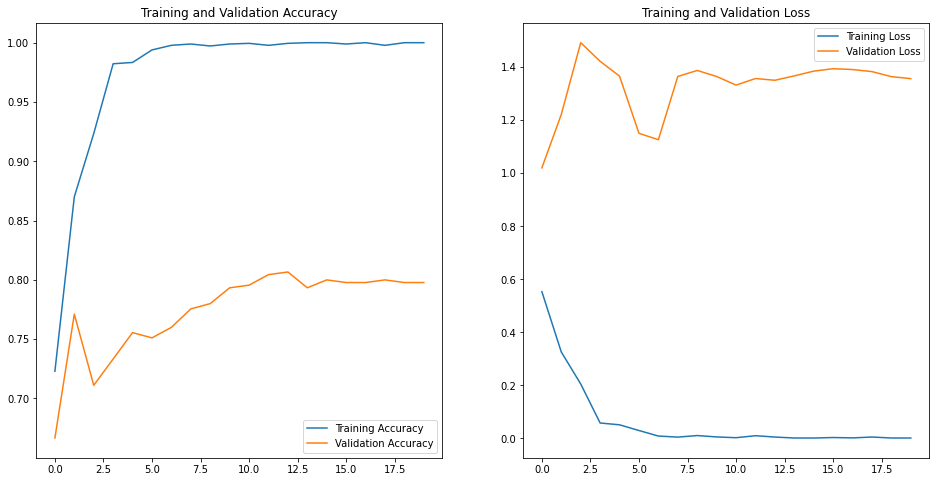

In [ ]:
plot_training_results(history_eff)

### Evaluate Model

In [ ]:
# get results
test_set.reset()
results = model_effnet.evaluate(test_set, steps = len(test_set), verbose = 1, return_dict = True)

16/16 [==============================] - 1s 70ms/step - loss: 1.6240 - accuracy: 0.6560 - tp: 162.0000 - fp: 85.0000 - tn: 165.0000 - fn: 88.0000 - BinaryAccuracy: 0.6540 - precision: 0.6559 - recall: 0.6480 - auc: 0.6695


In [ ]:
# show results
print('EfficientNetB4:')
print('---------------')
print("Accuracy:",(results['accuracy']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB4:
---------------
Accuracy: 0.656000018119812
Binary Accuracy: 0.6539999842643738
Precision: 0.6558704376220703
Recall: 0.6480000019073486
AUC: 0.6695440411567688
F1 Score: 0.6519114659635412


### Predict Images

[1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0]
[1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0]

Classification Report
              precision    recall  f1-score   support

      Normal       0.62      0.71      0.67         7
      Stroke       0.75      0.67      0.71         9

   micro avg       0.69      0.69      0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.70      0.69      0.69        16
 samples avg       0.69      0.69      0.69        16

Confusion Matrix
[[5 2]
 [3 6]]


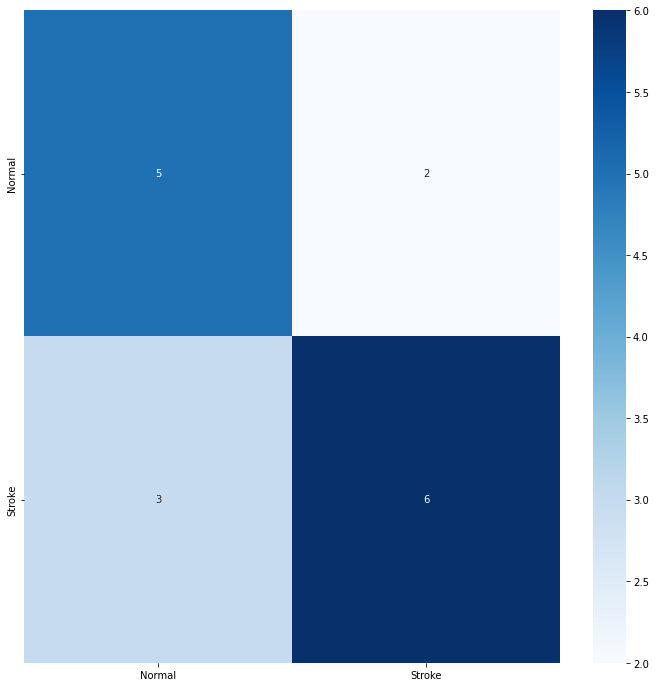

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

images, labels = next(test_set)

Y_pred = model_effnet.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print(y_pred.argmax(axis=1))
print(labels.argmax(axis=1))

print('\nClassification Report')
print(classification_report(labels, y_pred, target_names = CLASSES))

confusionmatrix = confusion_matrix(labels.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = CLASSES, yticklabels = CLASSES)

## Manifolds

**Auxiliar Functions**

In [ ]:
# For plotting
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict(l=100,r=100,b=100,t=100),width=1200,height=800)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

def plot_3d(component1,component2,component3):

    fig = go.Figure(data=[go.Scatter3d(
            x=component1,
            y=component2,
            z=component3,
            mode='markers',
            marker=dict(
                size=10,
                color=y,                # set color to an array/list of desired values
                colorscale='Rainbow',   # choose a colorscale
                opacity=1,
                line_width=1
            )
        )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1200,height=800)
    fig.layout.template = 'plotly_dark'
    
    fig.show()

### Create dataframe

In [ ]:
from keras.applications.efficientnet import preprocess_input
from keras.preprocessing import image
import numpy as np

img_path = '/content/dataset/Brain_Data_Organised/Train/Stroke/97 (5).jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

model_effnet_notop = tf.keras.models.Model(inputs = model_effnet.input,
                                           outputs = model_effnet.get_layer("top_activation").output)

eff_feature = model_effnet_notop.predict(img_data)

print(eff_feature.shape)

(1, 7, 7, 1792)


In [ ]:
valid_set.reset()
Y_pred_notop = model_effnet_notop.predict(valid_set)
y_pred_notop = Y_pred_notop.argmax(axis=1)
# Y_pred = model_effnet.predict(valid_set)

eff_feature_list = []

for y_pred in y_pred_notop:
  eff_feature_np = np.array(y_pred)
  eff_feature_flatten = eff_feature_np.flatten()
  eff_feature_list.append(eff_feature_flatten)

eff_feature_list_np = np.array(eff_feature_list)

In [ ]:
# create dataframe with 300 features for each image
import pandas as pd

df = pd.DataFrame()  

labels = get_classes(valid_set)

columns = []
columns.append('label')
for i in range(len(eff_feature_flatten[:300])):
  columns.append("feature_" + str(i+1))
  i = i+1

df = pd.DataFrame(columns=columns)

for i in range(len(labels)):
  eff_feature = eff_feature_list_np[i]
  df.at[i, columns[0]] = labels[i] 
  for j in range(len(eff_feature[:300])):
    df.at[i, columns[j+1]] = eff_feature[j]

In [ ]:
df.head()

label feature_1 feature_2  ... feature_298 feature_299 feature_300
0     0         5         5  ...           5           5           1
1     1         3         3  ...           5           3           5
2     0         1         1  ...           1           5           6
3     1         4         4  ...           5           4           5
4     1         4         1  ...           1           4           3

[5 rows x 301 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Columns: 301 entries, label to feature_300
dtypes: object(301)
memory usage: 1.1+ MB


In [ ]:
y = df.loc[:,'label'].values
x = df.loc[:,'feature_1':].values

In [ ]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
x = StandardScaler().fit_transform(x)

### PCA

In [ ]:
#PCA
from sklearn.decomposition import PCA
import time

start = time.time()
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
print('Duration: {} seconds'.format(time.time() - start))
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

Duration: 0.05240893363952637 seconds


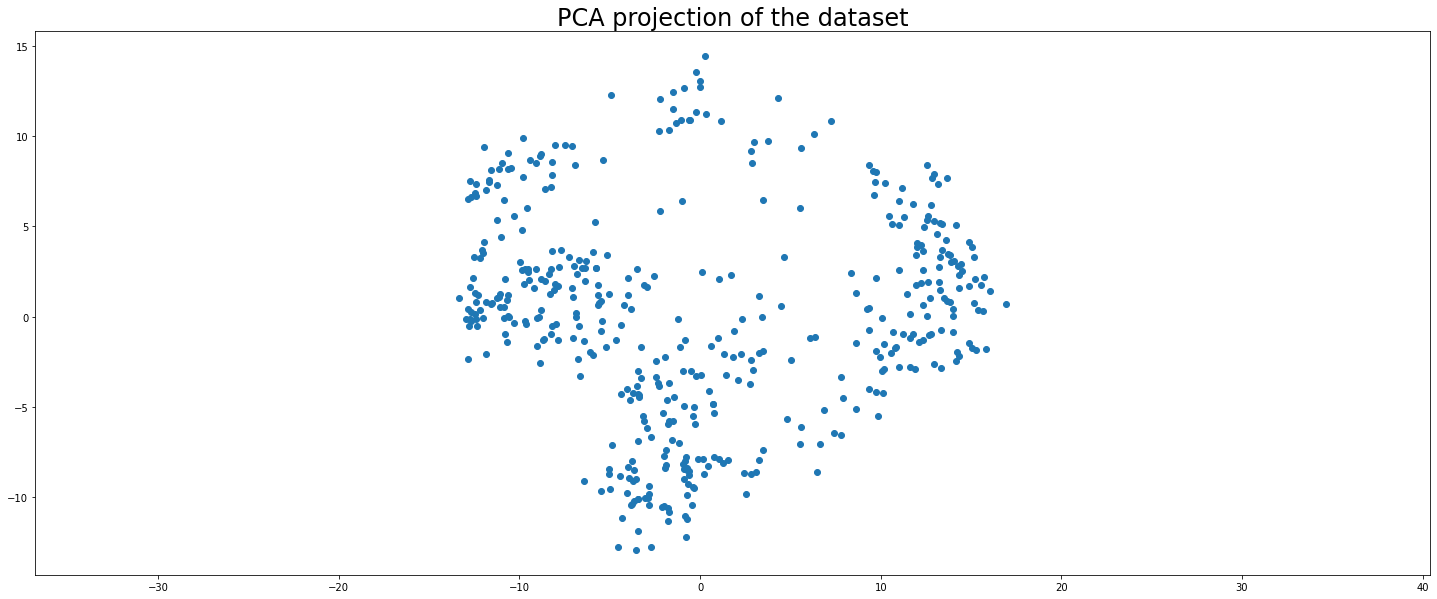

In [ ]:
plot_2d(principalComponents[:, 0],principalComponents[:, 1])
print2D(principalComponents, "PCA projection of the dataset")

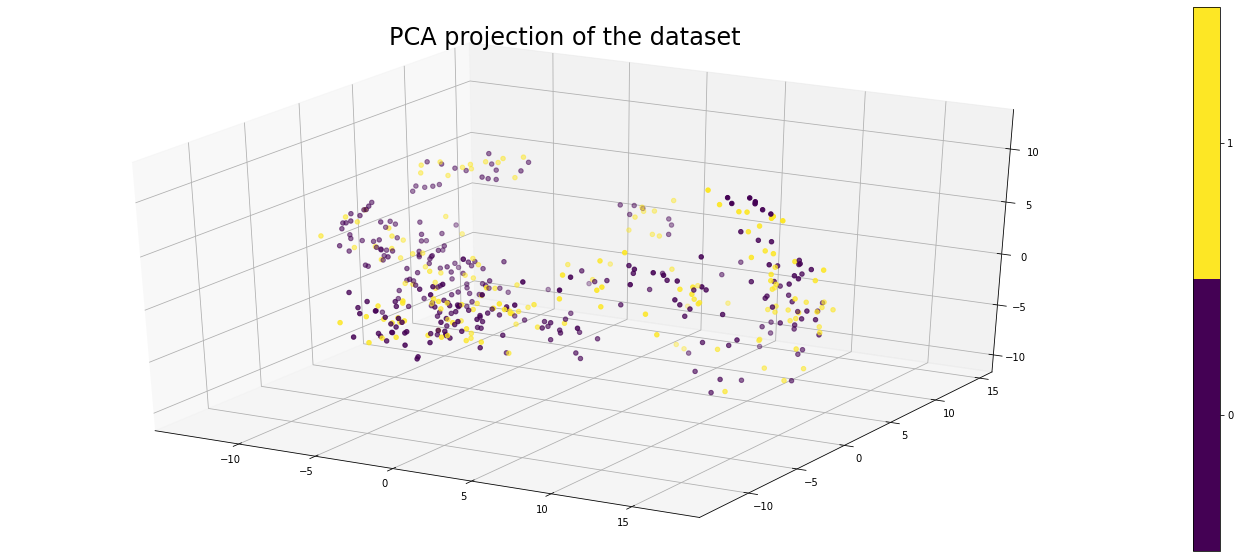

In [ ]:
plot_3d(principalComponents[:, 0],principalComponents[:, 1],principalComponents[:, 2])
print3D(principalComponents, "PCA projection of the dataset", labels)

### Isomap

In [ ]:
from sklearn.manifold import Isomap

start = time.time()
isomap = Isomap(n_components=3, n_neighbors=20).fit_transform(x) 
print('Duration: {} seconds'.format(time.time() - start))

Duration: 0.18242979049682617 seconds


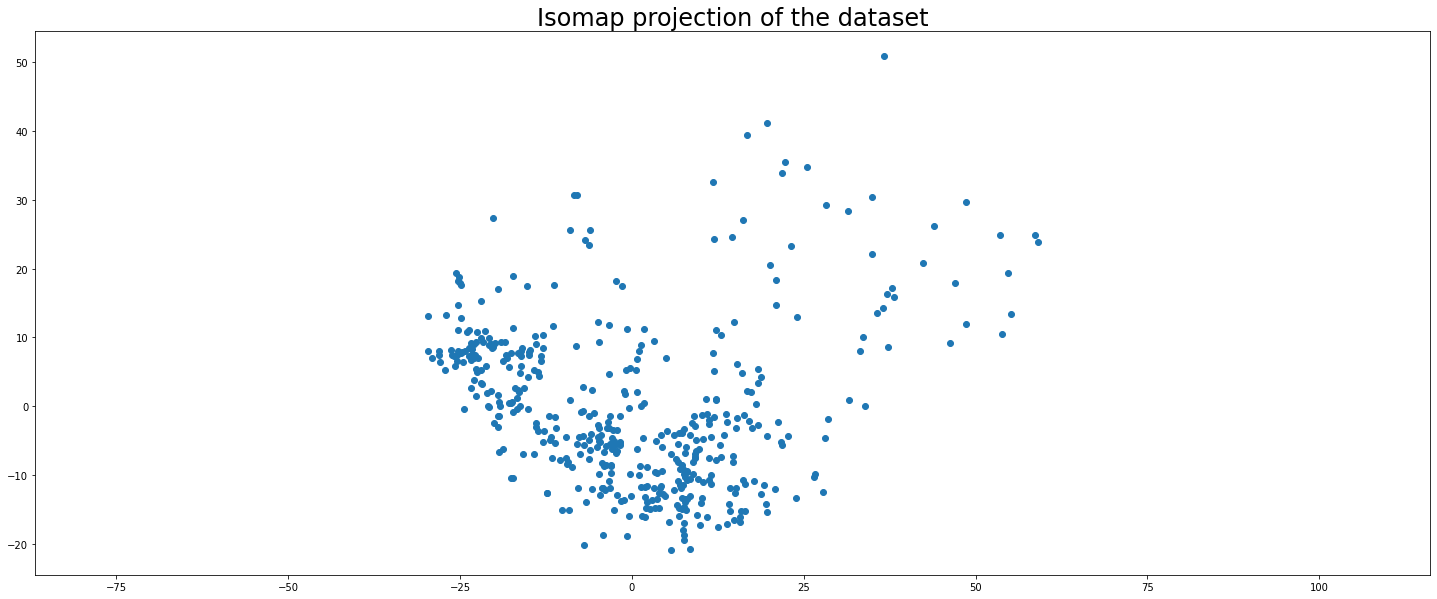

In [ ]:
plot_2d(isomap[:, 0],isomap[:, 1])
print2D(isomap, "Isomap projection of the dataset")

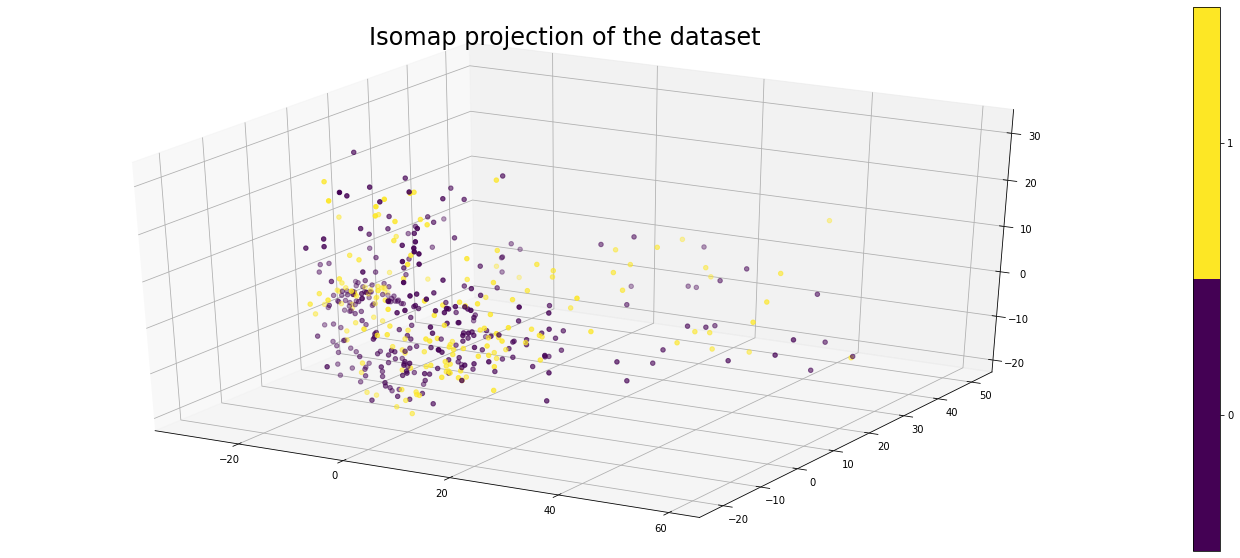

In [ ]:
plot_3d(isomap[:, 0],isomap[:, 1],isomap[:, 2])
print3D(isomap, "Isomap projection of the dataset", labels)

### LLE

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

start = time.time()
lle = LocallyLinearEmbedding(n_components=3,n_neighbors=20).fit_transform(x) 
print('Duration: {} seconds'.format(time.time() - start))

Duration: 0.1934518814086914 seconds


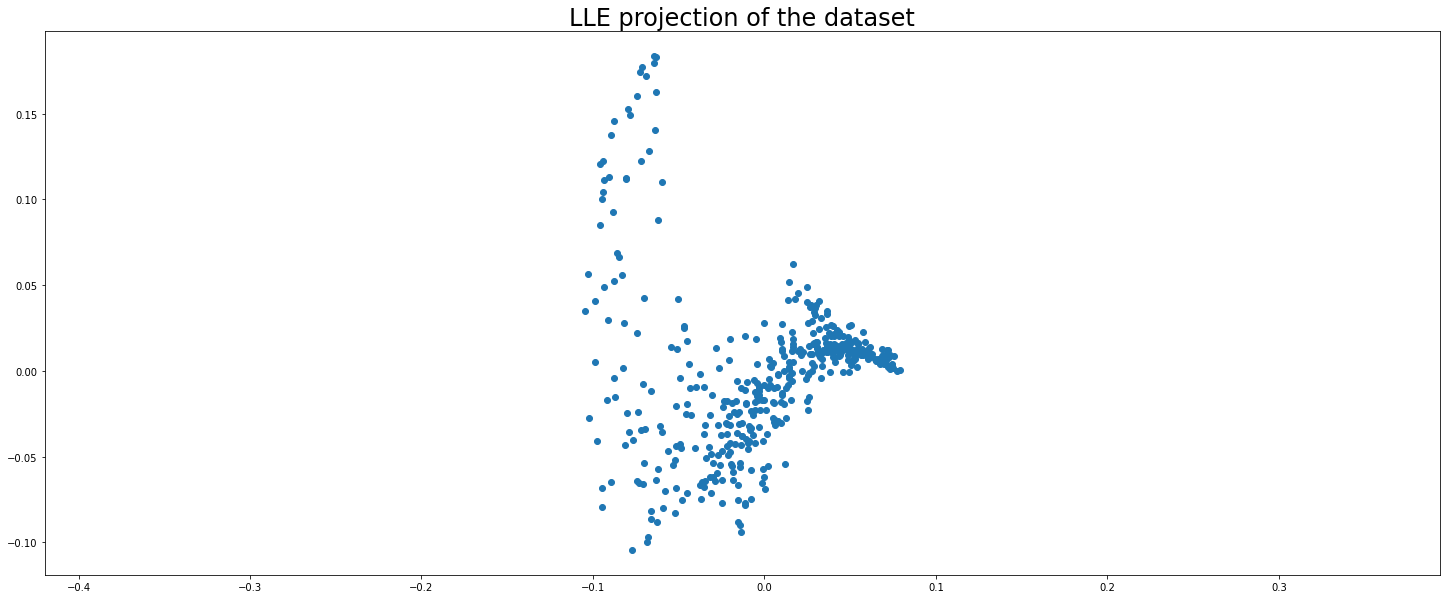

In [ ]:
plot_2d(lle[:, 0],lle[:, 1])
print2D(lle, "LLE projection of the dataset")

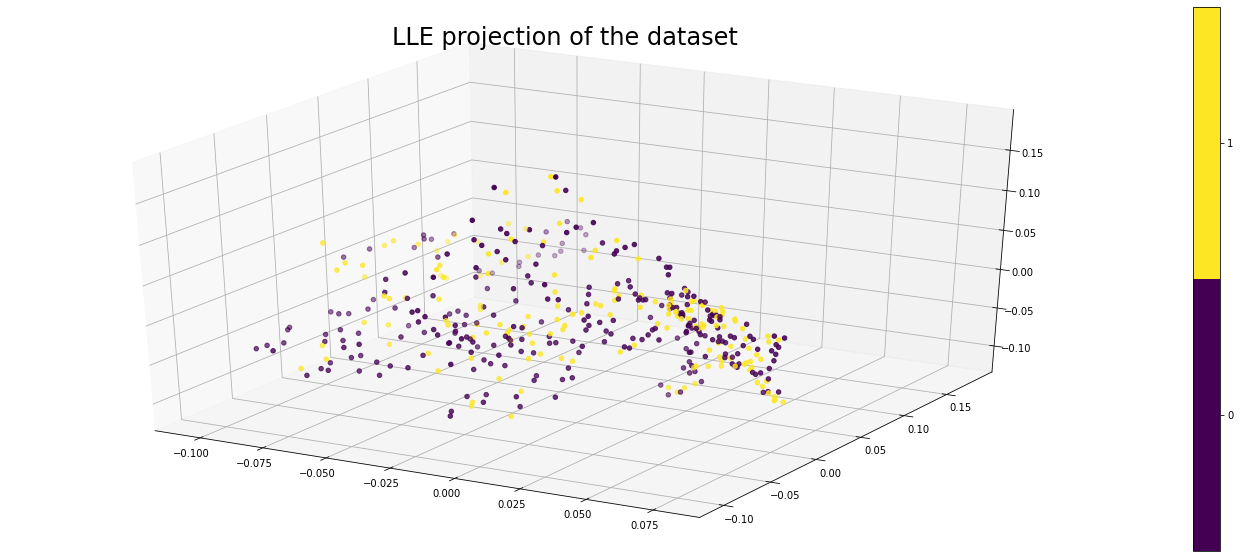

In [ ]:
plot_3d(lle[:, 0],lle[:, 1],lle[:, 2])
print3D(lle, "LLE projection of the dataset", labels)

### T-SNE

In [ ]:
#TSNE
from sklearn.manifold import TSNE

start = time.time()
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x)
tsne = TSNE(random_state = 42, n_components=3,verbose=True, perplexity=40, n_iter=400).fit_transform(pca_result_50)
print('Duration: {} seconds'.format(time.time() - start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 450 samples in 0.000s...
[t-SNE] Computed neighbors for 450 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 450 / 450
[t-SNE] Mean sigma: 6.431634
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.906372
[t-SNE] KL divergence after 400 iterations: 2.103582
Duration: 9.65892767906189 seconds


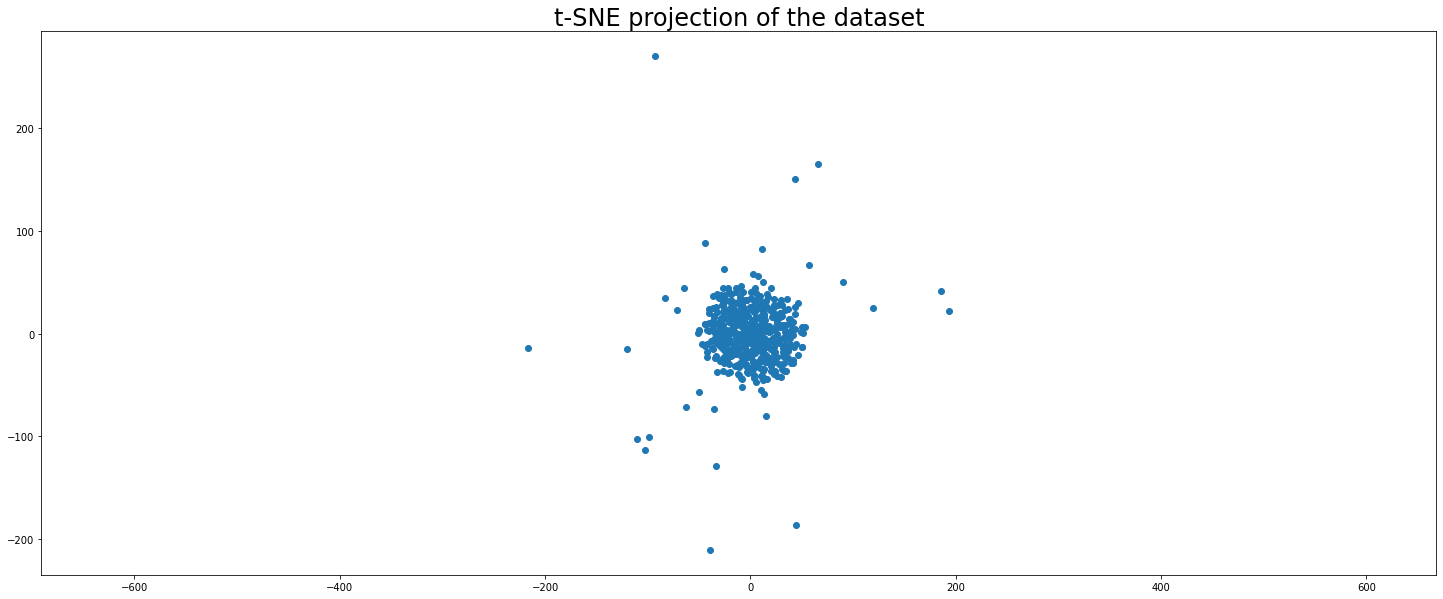

In [ ]:
plot_2d(tsne[:, 0],tsne[:, 1])
print2D(tsne, "t-SNE projection of the dataset")

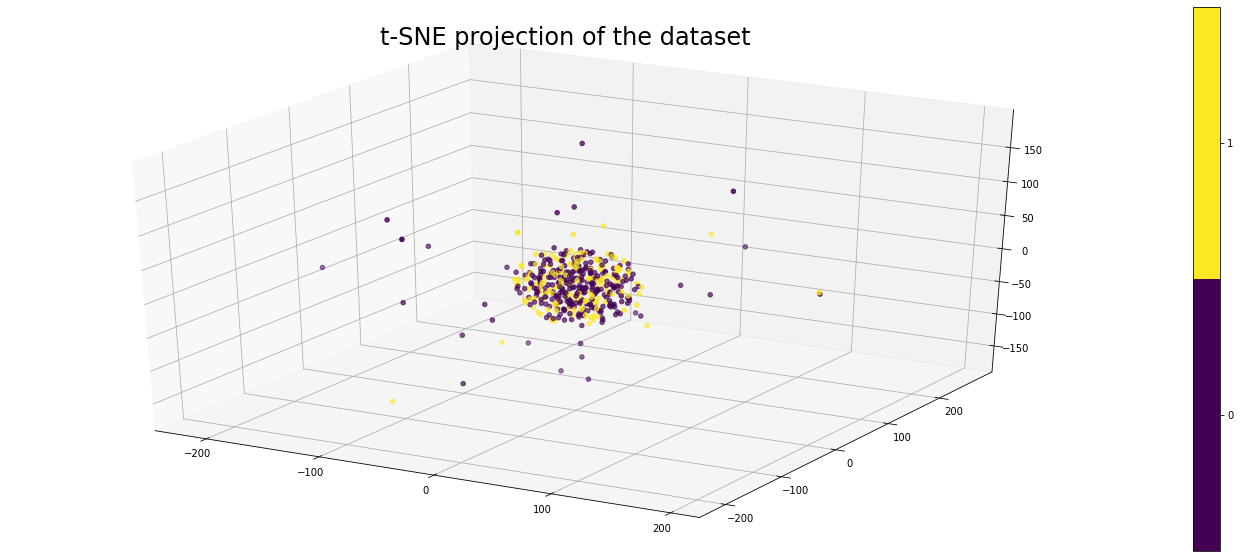

In [ ]:
plot_3d(tsne_embedding[:, 0],tsne_embedding[:, 1],tsne_embedding[:, 2])
print3D(tsne_embedding, "t-SNE projection of the dataset", labels)

### UMAP

In [ ]:
!pip install umap-learn[plot]

In [ ]:
#UMAP
import umap
import time

# unsupervised
# start = time.time()
# reducer = umap.UMAP(random_state=42,n_components=3)
# embedding = reducer.fit_transform(x)
# print('Duration: {} seconds'.format(time.time() - start))

# supervised
start = time.time()
reducer = umap.UMAP(n_components = 3, n_neighbors = 20, verbose = True)
umap_transformer = reducer.fit(x, labels)
embedding = umap_transformer.transform(x)
print('Duration: {} seconds'.format(time.time() - start))

UMAP(n_components=3, n_neighbors=20, verbose=True)
Tue Dec 14 03:20:25 2021 Construct fuzzy simplicial set
Tue Dec 14 03:20:25 2021 Finding Nearest Neighbors
Tue Dec 14 03:20:28 2021 Finished Nearest Neighbor Search
Tue Dec 14 03:20:30 2021 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Dec 14 03:20:33 2021 Finished embedding
Duration: 8.730144262313843 seconds


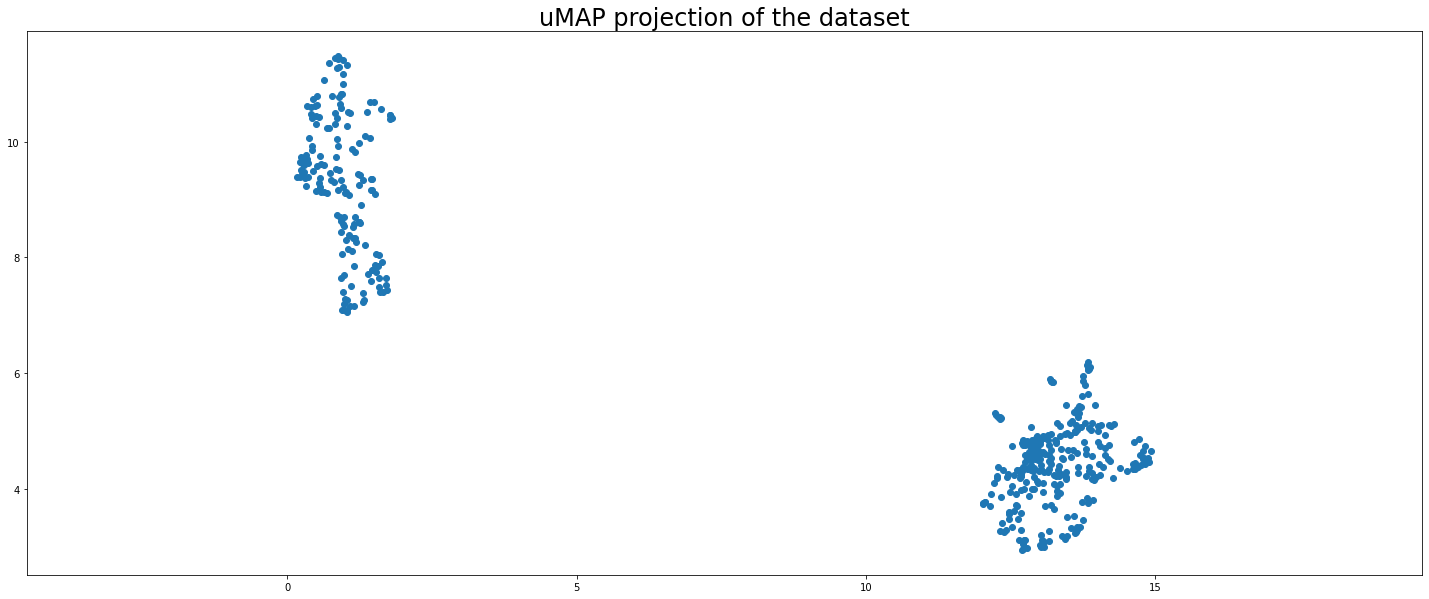

In [ ]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1])
print2D(embedding, "uMAP projection of the dataset")

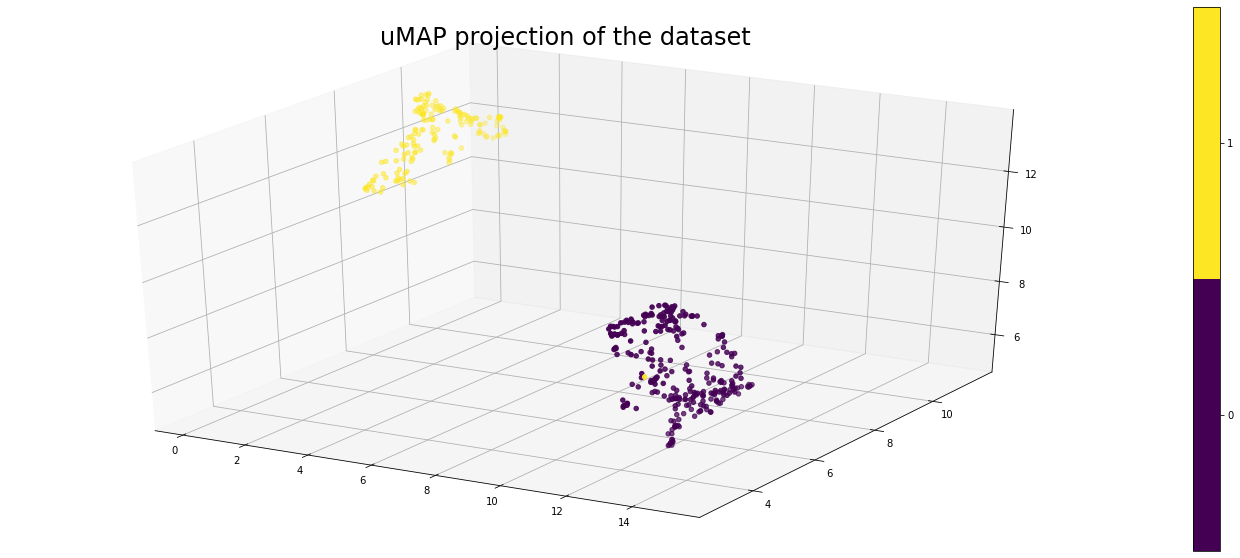

In [ ]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2])
print3D(embedding, "uMAP projection of the dataset", labels)

## ViT B32

### Build Model

In [15]:
!pip install -U vit-keras
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.4 MB/s 


In [16]:
# build vit model with 32 patch_size
from vit_keras import vit

base_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = NUM_CLASSES)
base_model.trainable = True

x = base_model.output
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid', name = 'Final')(x)
model_vit = tf.keras.models.Model(name = "vit_b16", inputs = base_model.input, outputs = predictions)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_vit.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

353263616/353253686 [==============================] - 5s 0us/step


In [17]:
model_vit.summary()

Model: "vit_b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

### Train Model

In [ ]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb32')
history_vit = model_vit.fit(train_set,
                            epochs = EPOCHS,
                            validation_data = valid_set,
                            callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-16 00:40:41.313890
Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.6596 - tp: 1166.0000 - fp: 595.0000 - tn: 1206.0000 - fn: 635.0000 - BinaryAccuracy: 0.6585 - precision: 0.6621 - recall: 0.6474 - auc: 0.7079
Epoch 00001: val_loss improved from inf to 0.61458, saving model to model.vitb32.h5
113/113 [==============================] - 67s 346ms/step - loss: 0.6618 - accuracy: 0.6596 - tp: 1166.0000 - fp: 595.0000 - tn: 1206.0000 - fn: 635.0000 - BinaryAccuracy: 0.6585 - precision: 0.6621 - recall: 0.6474 - auc: 0.7079 - val_loss: 0.6146 - val_accuracy: 0.7356 - val_tp: 333.0000 - val_fp: 127.0000 - val_tn: 323.0000 - val_fn: 117.0000 - val_BinaryAccuracy: 0.7289 - val_precision: 0.7239 - val_recall: 0.7400 - val_auc: 0.7499 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 0.4302 - accuracy: 0.7984 - tp: 1437.0000 - fp: 359.0000 - tn: 1442.0000 - fn: 364.0000 - BinaryAccuracy: 0.7993 - precision: 0.80

In [34]:
!cp '/content/model.vitb32.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.vitb32.h5'

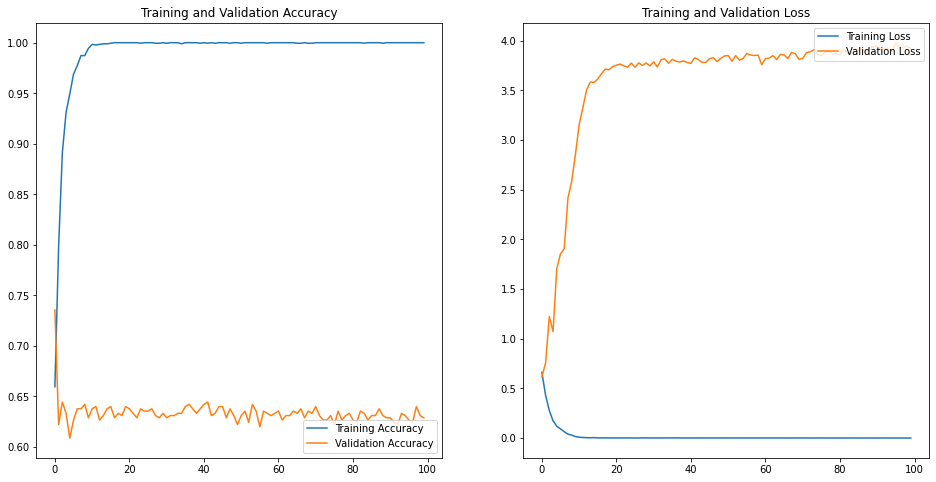

In [35]:
plot_training_results(history_vit)

### Evaluate Model

In [36]:
# get results
test_set.reset()
results = model_vit.evaluate(test_set, steps = len(test_set), verbose = 1, return_dict = True)

16/16 [==============================] - 2s 96ms/step - loss: 3.1492 - accuracy: 0.6800 - tp: 170.0000 - fp: 80.0000 - tn: 170.0000 - fn: 80.0000 - BinaryAccuracy: 0.6800 - precision: 0.6800 - recall: 0.6800 - auc: 0.7219


In [37]:
# show results
print('ViT B32:')
print('---------------')
print("Accuracy:",(results['accuracy']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT B32:
---------------
Accuracy: 0.6800000071525574
Binary Accuracy: 0.6800000071525574
Precision: 0.6800000071525574
Recall: 0.6800000071525574
AUC: 0.7219040989875793
F1 Score: 0.6800000071525574


### Predict Images

[0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1]
[1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0]

Classification Report
              precision    recall  f1-score   support

      Normal       0.50      0.71      0.59         7
      Stroke       0.67      0.44      0.53         9

   micro avg       0.56      0.56      0.56        16
   macro avg       0.58      0.58      0.56        16
weighted avg       0.59      0.56      0.56        16
 samples avg       0.56      0.56      0.56        16

Confusion Matrix
[[5 2]
 [5 4]]


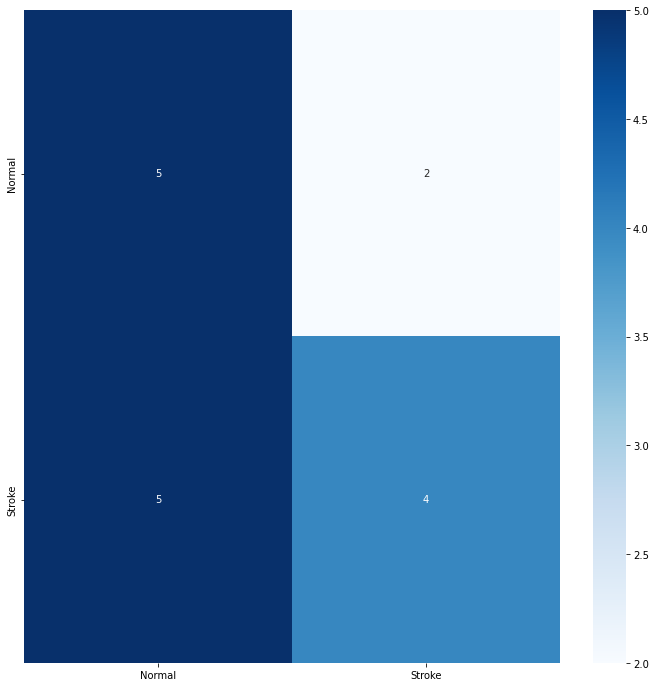

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

images, labels = next(test_set)

Y_pred = model_vit.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print(y_pred.argmax(axis=1))
print(labels.argmax(axis=1))

print('\nClassification Report')
print(classification_report(labels, y_pred, target_names = CLASSES))

confusionmatrix = confusion_matrix(labels.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = CLASSES, yticklabels = CLASSES)

## Manifolds

**Auxiliar Functions**

In [53]:
# For plotting
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict(l=100,r=100,b=100,t=100),width=1200,height=800)                 
    # fig.layout.template = 'plotly_dark'
    
    fig.show()

def plot_3d(component1,component2,component3):

    fig = go.Figure(data=[go.Scatter3d(
            x=component1,
            y=component2,
            z=component3,
            mode='markers',
            marker=dict(
                size=10,
                color=y,                # set color to an array/list of desired values
                colorscale='Rainbow',   # choose a colorscale
                opacity=1,
                line_width=1
            )
        )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1200,height=800)
    # fig.layout.template = 'plotly_dark'
    
    fig.show()

### Create dataframe

In [40]:
from keras.applications.efficientnet import preprocess_input
from keras.preprocessing import image
import numpy as np

img_path = '/content/dataset/Brain_Data_Organised/Train/Stroke/97 (5).jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

model_vit_notop = tf.keras.models.Model(inputs = model_vit.input,
                                        outputs = model_vit.get_layer("Transformer/encoder_norm").output)

vit_feature = model_vit_notop.predict(img_data)

print(vit_feature.shape)

(1, 50, 768)


In [41]:
valid_set.reset()
Y_pred_vit_notop = model_vit_notop.predict(valid_set)
y_pred_vit_notop = Y_pred_vit_notop.argmax(axis=1)

vit_feature_list = []

for y_pred in y_pred_vit_notop:
  vit_feature_np = np.array(y_pred)
  vit_feature_flatten = vit_feature_np.flatten()
  vit_feature_list.append(vit_feature_flatten)

vit_feature_list_np = np.array(vit_feature_list)

In [42]:
# create dataframe with 300 features for each image
import pandas as pd

df = pd.DataFrame()  

labels = get_classes(valid_set)

columns = []
columns.append('label')
for i in range(len(vit_feature_flatten[:300])):
  columns.append("feature_" + str(i+1))
  i = i+1

df = pd.DataFrame(columns=columns)

for i in range(len(labels)):
  vit_feature = vit_feature_list_np[i]
  df.at[i, columns[0]] = labels[i] 
  for j in range(len(vit_feature[:300])):
    df.at[i, columns[j+1]] = vit_feature[j]

In [43]:
df.head()

label feature_1 feature_2  ... feature_298 feature_299 feature_300
0     0        41        29  ...           2          29          48
1     1        12        48  ...           3           6          48
2     1         9        28  ...          15          38           0
3     0        29        49  ...          42          22          43
4     0        35        42  ...           9          45          48

[5 rows x 301 columns]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Columns: 301 entries, label to feature_300
dtypes: object(301)
memory usage: 1.1+ MB


In [45]:
y = df.loc[:,'label'].values
x = df.loc[:,'feature_1':].values

In [46]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
x = StandardScaler().fit_transform(x)

### PCA

In [47]:
#PCA
from sklearn.decomposition import PCA
import time

start = time.time()
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
print('Duration: {} seconds'.format(time.time() - start))
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

Duration: 0.07642531394958496 seconds


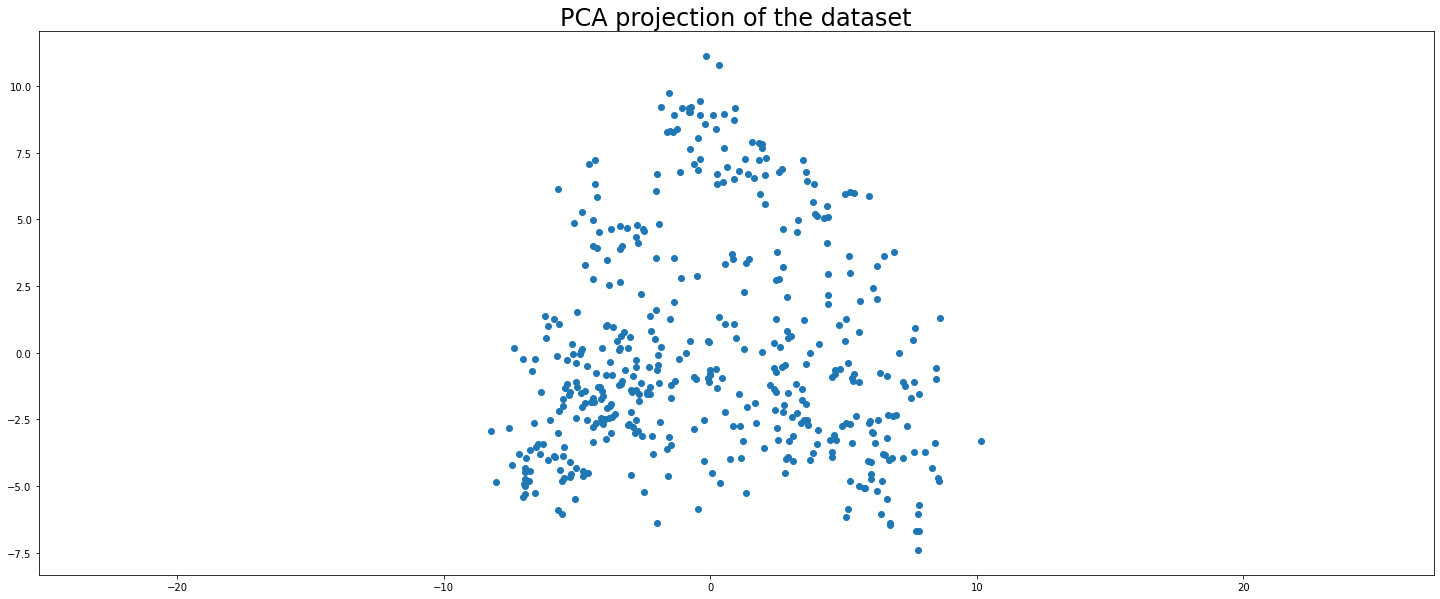

In [54]:
plot_2d(principalComponents[:, 0],principalComponents[:, 1])
print2D(principalComponents, "PCA projection of the dataset")

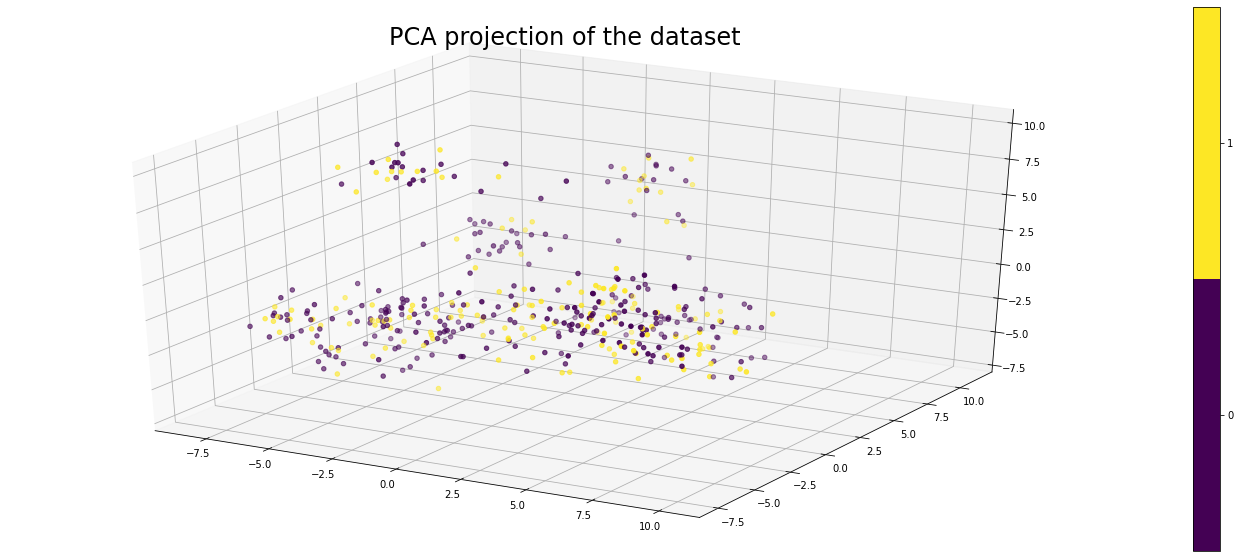

In [55]:
plot_3d(principalComponents[:, 0],principalComponents[:, 1],principalComponents[:, 2])
print3D(principalComponents, "PCA projection of the dataset", labels)

### Isomap

In [56]:
from sklearn.manifold import Isomap

start = time.time()
isomap = Isomap(n_components=3).fit_transform(x) 
print('Duration: {} seconds'.format(time.time() - start))

Duration: 0.1469860076904297 seconds


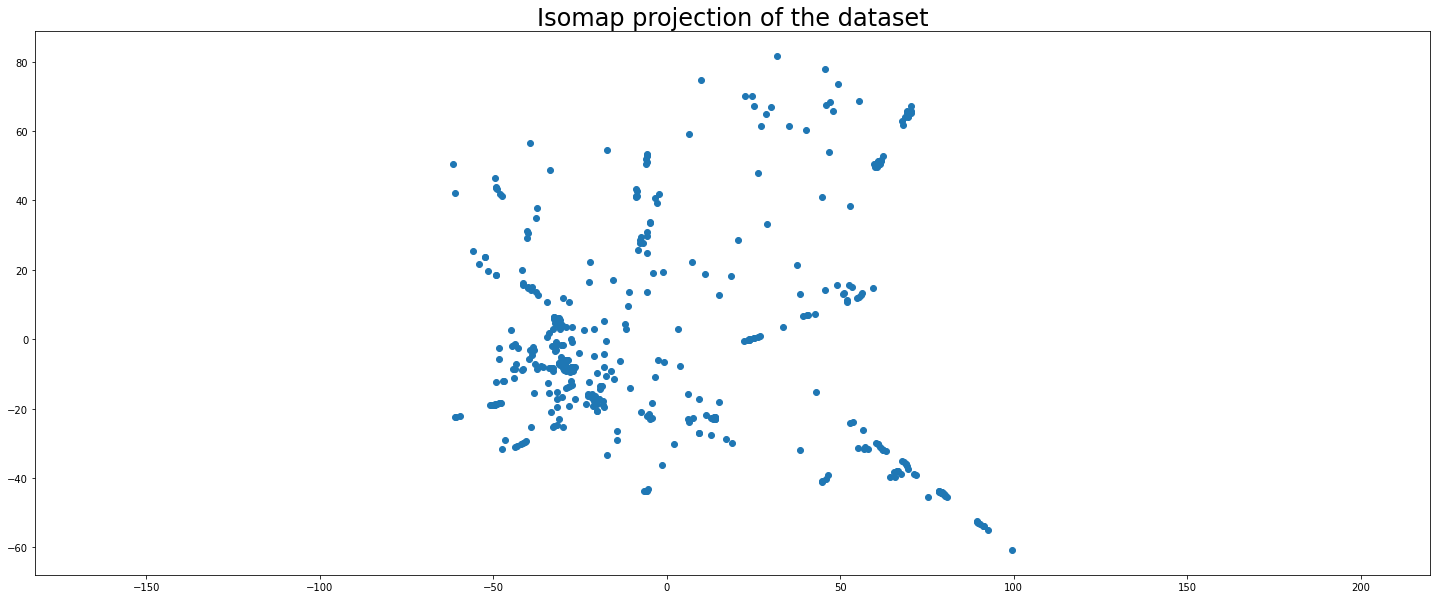

In [57]:
plot_2d(isomap[:, 0],isomap[:, 1])
print2D(isomap, "Isomap projection of the dataset")

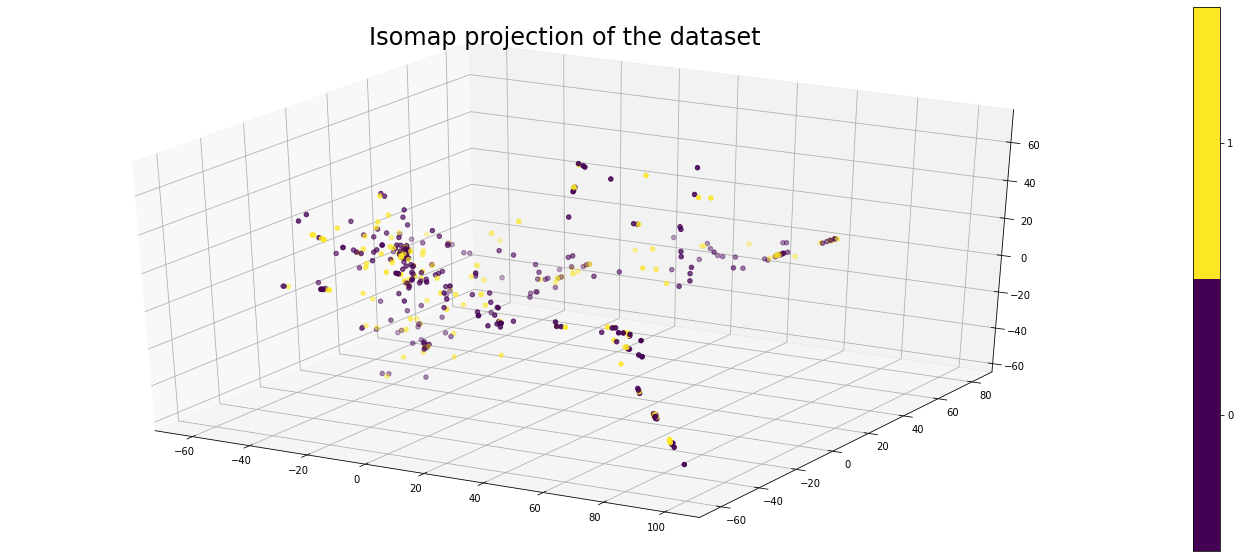

In [58]:
plot_3d(isomap[:, 0],isomap[:, 1],isomap[:, 2])
print3D(isomap, "Isomap projection of the dataset", labels)

### LLE

In [59]:
from sklearn.manifold import LocallyLinearEmbedding

start = time.time()
lle = LocallyLinearEmbedding(n_components=3).fit_transform(x) 
print('Duration: {} seconds'.format(time.time() - start))

Duration: 0.10775899887084961 seconds


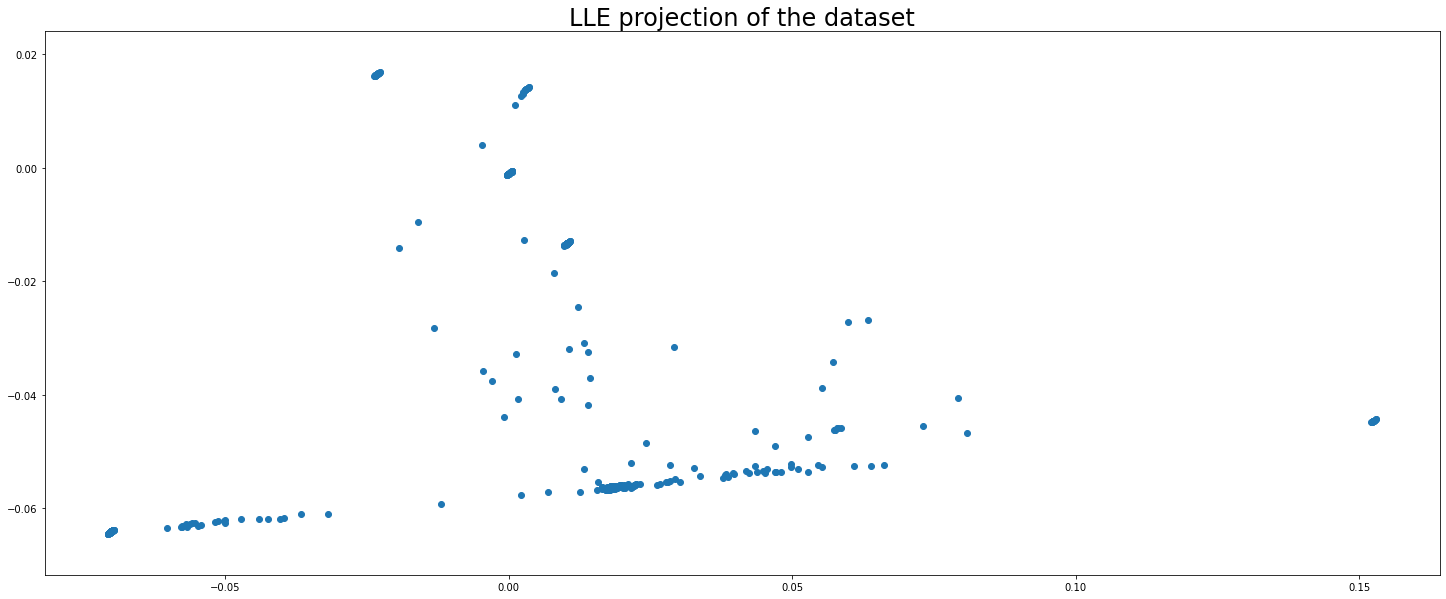

In [60]:
plot_2d(lle[:, 0],lle[:, 1])
print2D(lle, "LLE projection of the dataset")

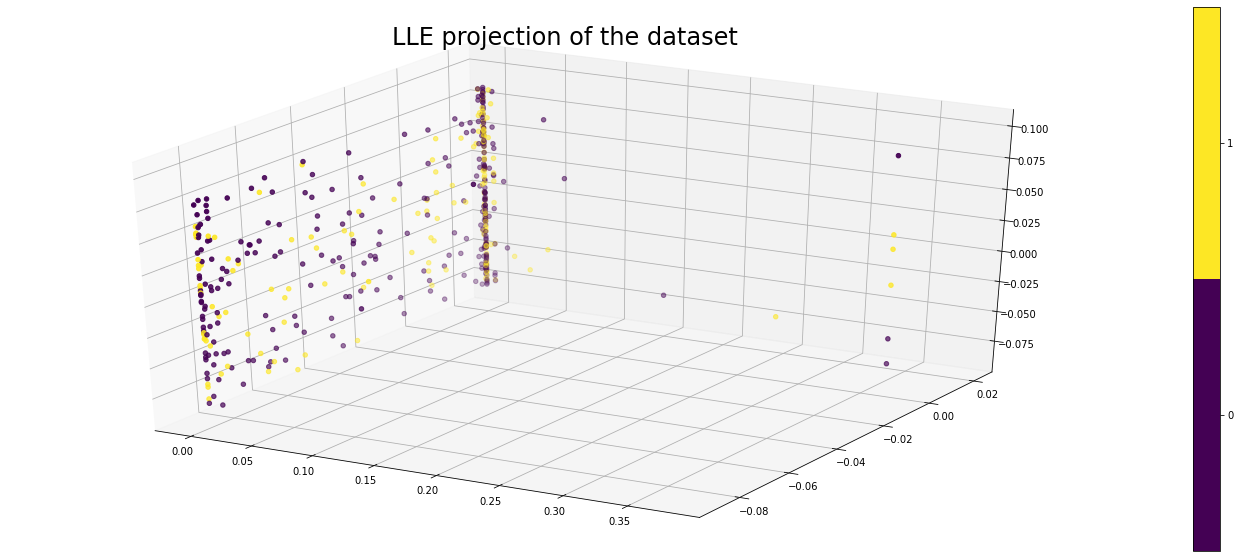

In [ ]:
plot_3d(lle[:, 0],lle[:, 1],lle[:, 2])
print3D(lle, "LLE projection of the dataset", labels)

### T-SNE

In [61]:
#TSNE
from sklearn.manifold import TSNE

start = time.time()
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x)
tsne = TSNE(random_state = 42, n_components=3,verbose=True, perplexity=20, n_iter=400).fit_transform(pca_result_50)
print('Duration: {} seconds'.format(time.time() - start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 450 samples in 0.001s...
[t-SNE] Computed neighbors for 450 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 450 / 450
[t-SNE] Mean sigma: 6.196707
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.813408
[t-SNE] KL divergence after 400 iterations: 2.550406
Duration: 2.76076340675354 seconds


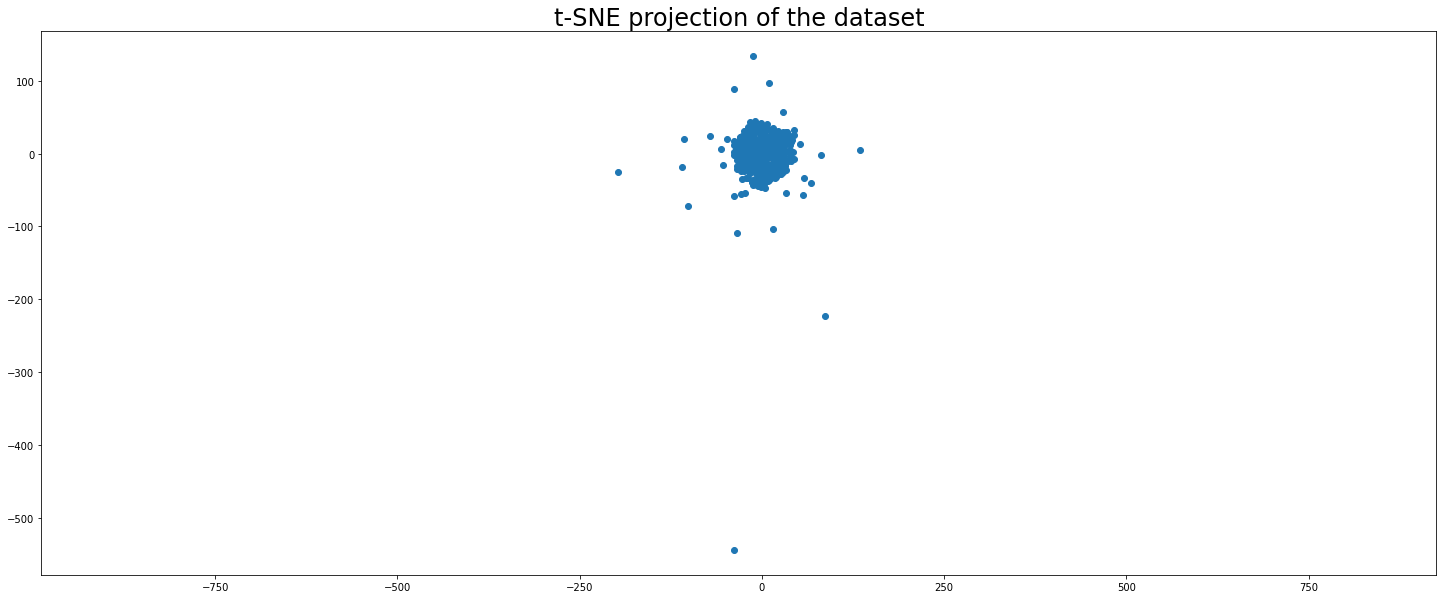

In [62]:
plot_2d(tsne[:, 0],tsne[:, 1])
print2D(tsne, "t-SNE projection of the dataset")

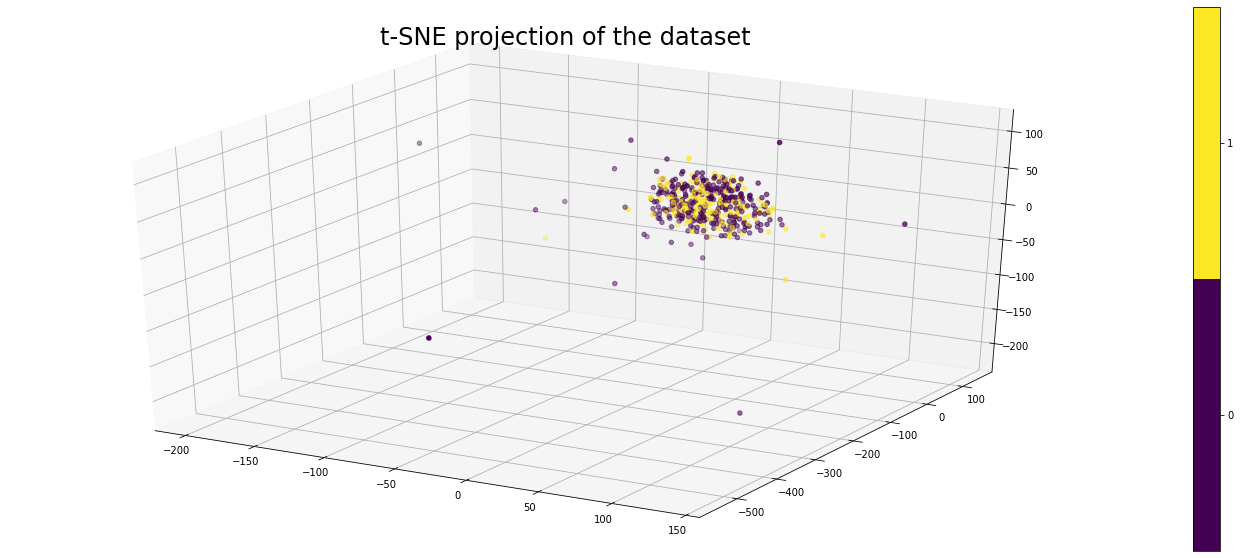

In [63]:
plot_3d(tsne[:, 0],tsne[:, 1],tsne[:, 2])
print3D(tsne, "t-SNE projection of the dataset", labels)

### UMAP

In [ ]:
!pip install umap-learn[plot]

In [65]:
#UMAP
import umap

# unsupervised
# start = time.time()
# reducer = umap.UMAP(random_state=42,n_components=3)
# embedding = reducer.fit_transform(x)
# print('Duration: {} seconds'.format(time.time() - start))

# supervised
start = time.time()
reducer = umap.UMAP(n_components = 3, n_neighbors = 20, verbose = True)
umap_transformer = reducer.fit(x, labels)
embedding = umap_transformer.transform(x)
print('Duration: {} seconds'.format(time.time() - start))

UMAP(n_components=3, n_neighbors=20, verbose=True)
Thu Dec 16 02:08:17 2021 Construct fuzzy simplicial set
Thu Dec 16 02:08:18 2021 Finding Nearest Neighbors
Thu Dec 16 02:08:22 2021 Finished Nearest Neighbor Search
Thu Dec 16 02:08:28 2021 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Dec 16 02:08:36 2021 Finished embedding
Duration: 18.61998701095581 seconds


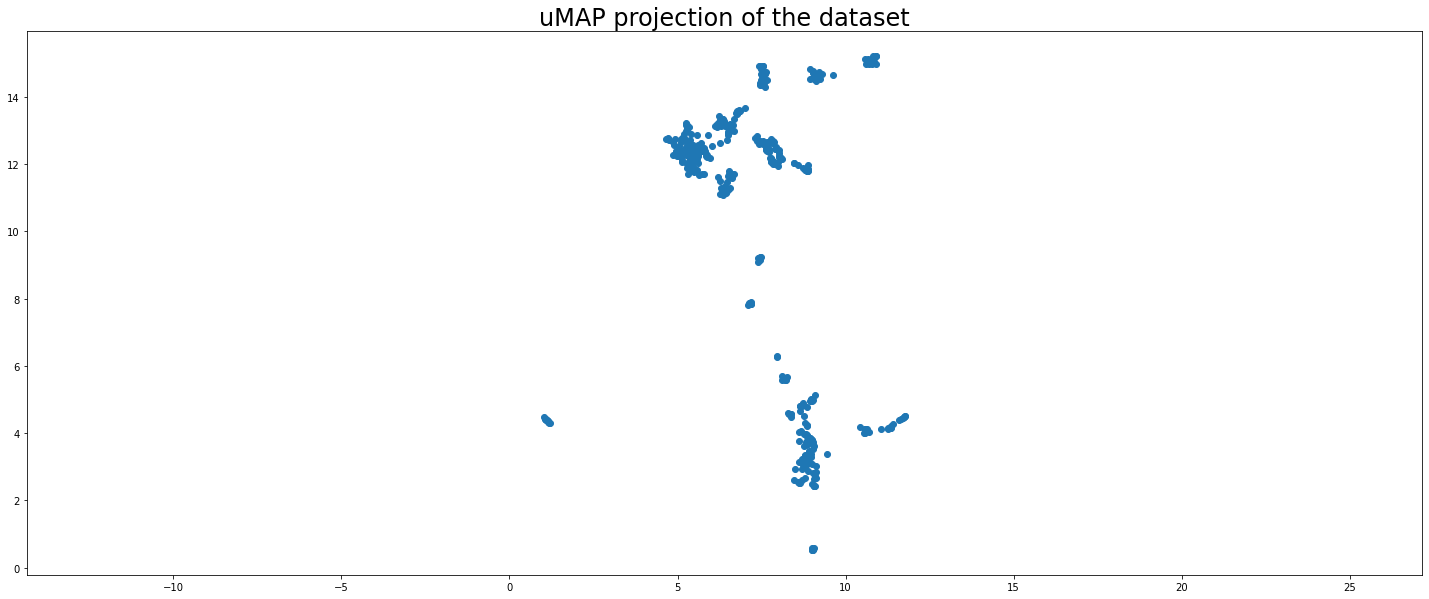

In [66]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1])
print2D(embedding, "uMAP projection of the dataset")

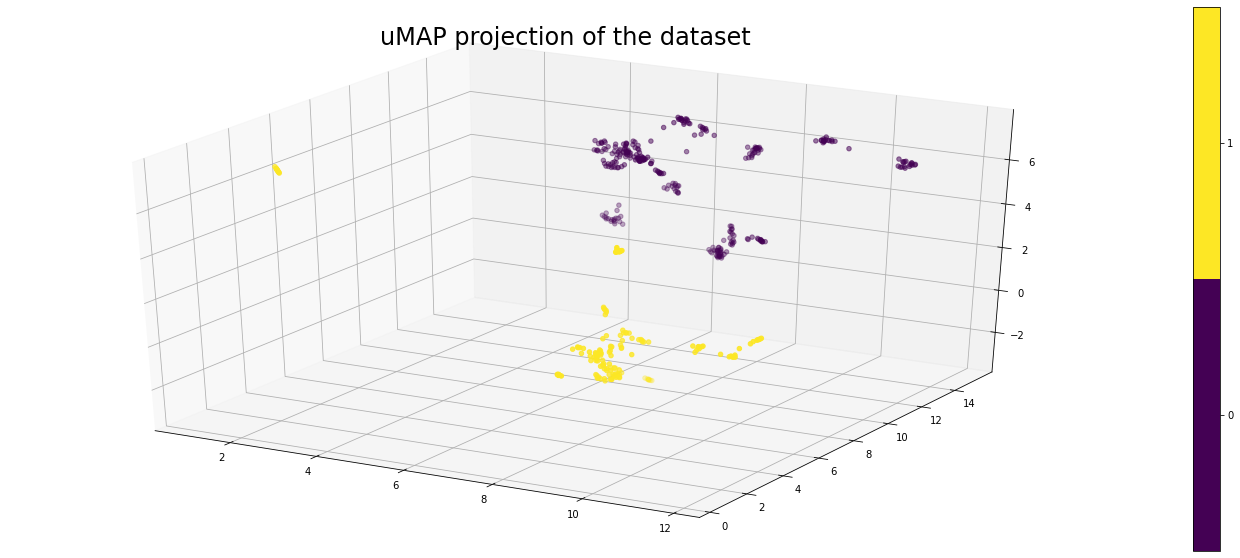

In [67]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2])
print3D(embedding, "uMAP projection of the dataset", labels)

In [68]:
# unsupervised
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(x)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 2.458479642868042 seconds


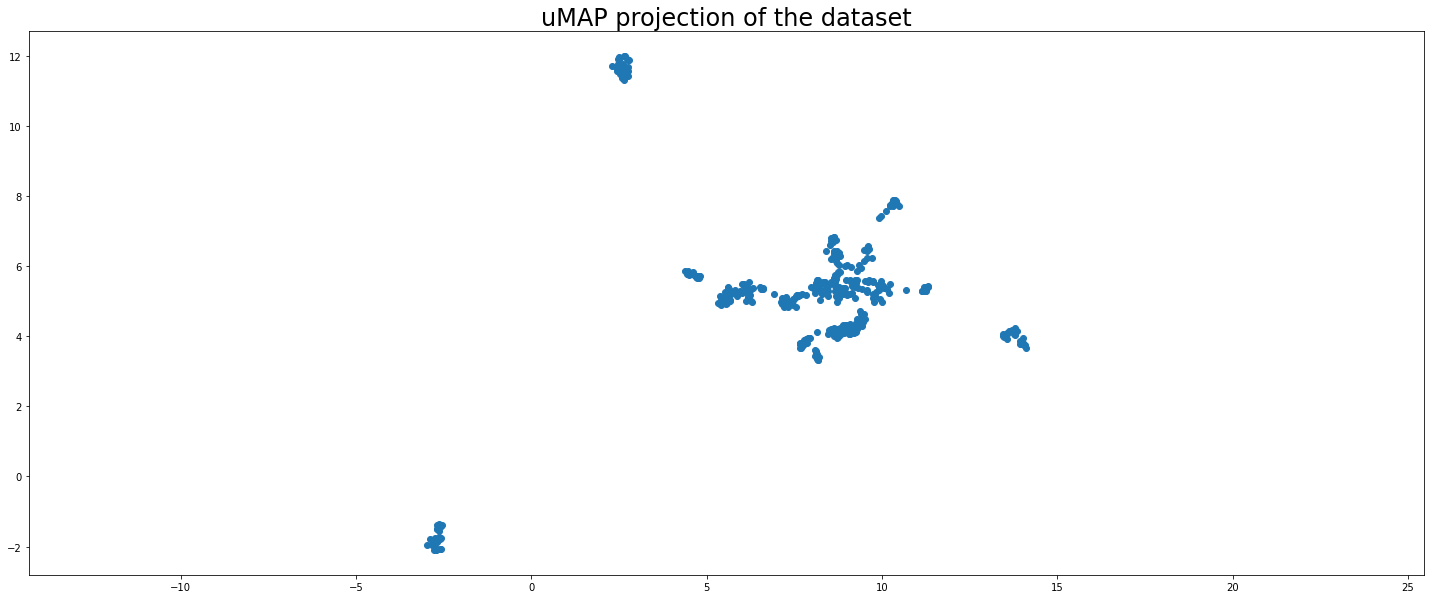

In [69]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1])
print2D(embedding, "uMAP projection of the dataset")

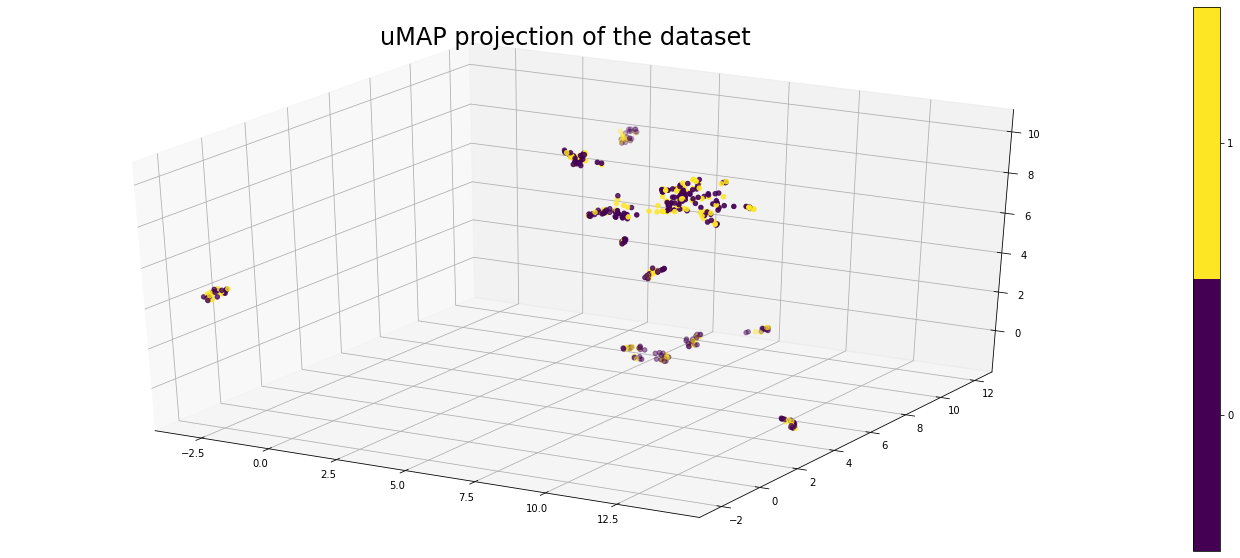

In [70]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2])
print3D(embedding, "uMAP projection of the dataset", labels)

# Predict Tests

In [ ]:
test_set.reset()
Y_pred_1 = model_vit.predict(test_set)
# y_pred_1 = (Y_pred_1 > 0.9).astype("int32")
y_pred_1 = Y_pred_1.argmax(axis=1)

In [ ]:
print(test_set.index_array)

[165 228 176   4  27 194  55 128 161  11  90 241  81  56   9 214 162 106
 129  18  63 155   6   5 141  76  24   7  23  37 240  78  62 107 142 187
 215  66 102  67 191  68 157  47 179  86  83 177 236  70  35  12 233 112
 104  74 220 131  39  22 116 109 113 218 127  73 242 243  58   3 143 156
  45 132 211 198 121 170  31  91  88 210  29  16 153 123  19  33  72  87
 217 115 229 184  80 164 216  64 181 126  57 125 234 103  75 175 213 144
 201 122 163  54 192  99   1 133 183 178  21 119 195 118 169 101  13  82
 135  51 202 203  89 150  32  38 182 167  49 221 232   0 117 224 206 171
 139 209 108 227   2  92 147 185 244 245  61 204  26 134  98  48 249 199
  94 186  30 239 140 158  44  71  43  59  93 152 226  95 148  50 136 196
 173 145  25 189 149  17 247  41  14  60 223 100 225 205 154 138 159 130
 193 231 120 207 222 151  53 172 235 200  84 146 124 168 230  15  34 137
  77  10  46 208 180 166  42 248 110  79 238 197  96 114 160 111  69 219
  28  52  40 237   8 212 246  85 190  97  20  65 10

In [ ]:
f_classes = []
idx_class = test_set.index_array
for idc in idx_class:
  f_classes.append(test_set.classes[idc])

In [ ]:
print(np.array(f_classes))

[1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1
 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1
 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1
 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1
 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1
 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1]


In [ ]:
print(Y_pred_1.argmax(axis=1))

[0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1
 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0
 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0]


In [ ]:
print(y_pred_1)

[0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1
 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0
 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0]



Classification Report
              precision    recall  f1-score   support

      Normal       0.51      0.64      0.57       125
      Stroke       0.52      0.38      0.44       125

    accuracy                           0.51       250
   macro avg       0.51      0.51      0.50       250
weighted avg       0.51      0.51      0.50       250

Confusion Matrix
[[80 45]
 [77 48]]


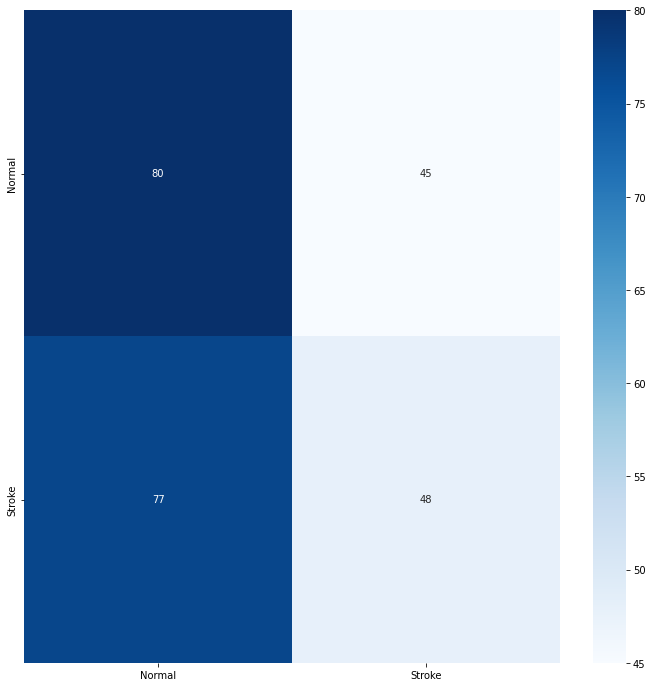

In [ ]:
print('\nClassification Report')
print(classification_report(f_classes, y_pred_1, target_names = CLASSES))

confusionmatrix = confusion_matrix(f_classes, y_pred_1)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = CLASSES, yticklabels = CLASSES)

# Manifolds Test

In [ ]:
valid_set.reset()
Y_pred_1 = model_effnet.predict(valid_set)
y_pred_1 = Y_pred_1.argmax(axis=1)
print(valid_set.index_array)

[ 98  63 327 185 269 241 131  11 261  90 280 107 275 259 300 224 154 378
 237 264  17 283 342 251 422 292 233 139 211   2 408 230 182 399 338 320
 238  16 345  58 433 220 322 286 362 398  92  36 236 334 317 405 252 396
 414 149 389 279 102  88 115 409  96  87 228 126 202 199  57 417 364 270
 357 449 370 310 386  38 318 301 121 325   3 375 171 282 391 161 426 239
 306 181 431  77 319 448 165 245 288 361 434 359 180  70 276 404 365 407
   1  60 360  99 223 156 420 119  85 303 351  31 368 382 243  26 298 175
  35 226 122  91 104 278 208 216  51 281 172 393  48 191 421 265 135 244
 201  21 174 134  29 329 293 436 287  75 186 411 145 235 127 203 257 204
 187 100 352 425 158  78 304 266 291 109 442  30 363 272  93 248 222 332
 151 443  46  42 129 295  19 385 294 212 302 153 105  37 441 358 118 152
  83 113  45 240  23 142 415 284 412   6 313 213 315 253 140 406 447  82
 343 123 379 103   0 194 254 285   9 200 141 258 337  22 183 184  71 164
  44 366 307 146 400 347 289 207 367 205  34 445 39

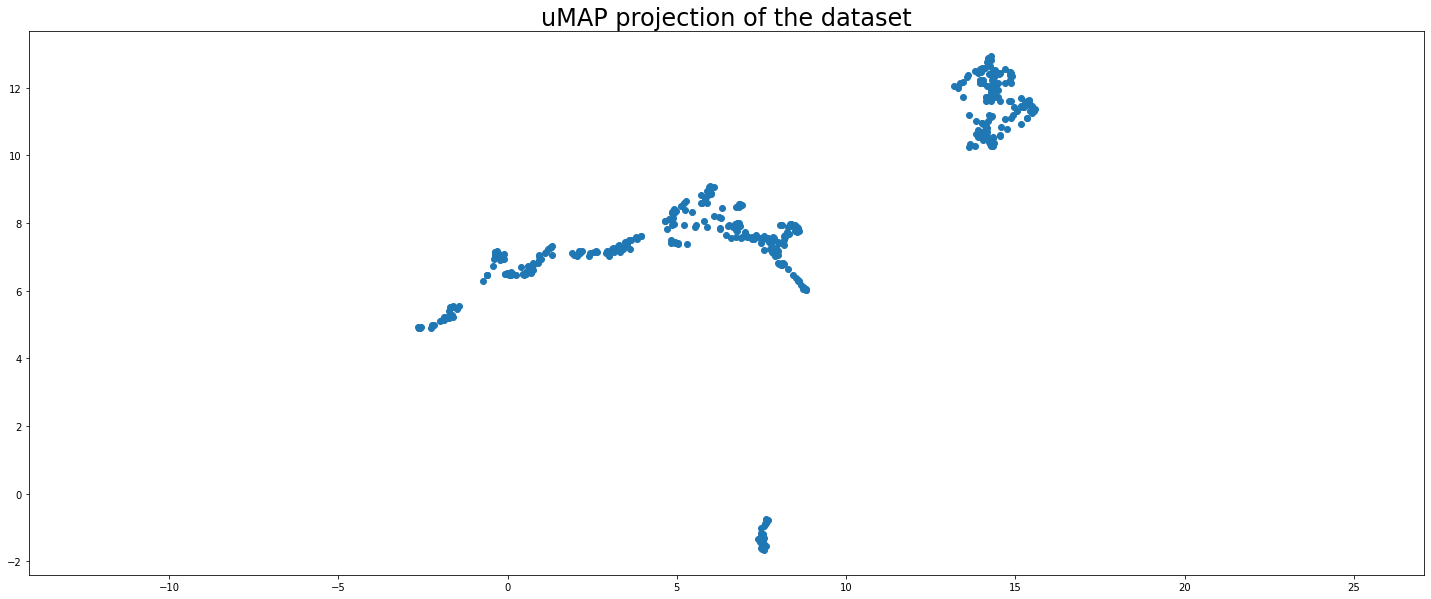

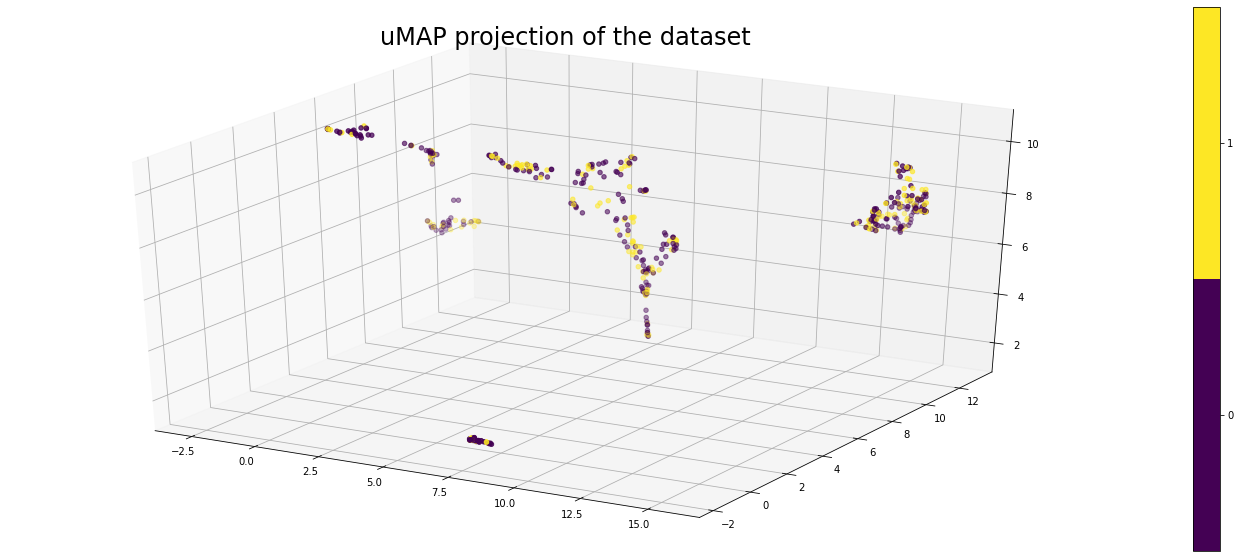

In [ ]:
featuresUMAP = uMAP(model_effnet, valid_set)
f_classes = get_classes(valid_set)
print2D(featuresUMAP, "uMAP projection of the dataset")
print3D(featuresUMAP, "uMAP projection of the dataset", f_classes)

In [ ]:
from keras.applications.efficientnet import preprocess_input
from keras.preprocessing import image
import numpy as np

img_path = '/content/dataset/Brain_Data_Organised/Train/Stroke/97 (5).jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

model_effnet_notop = tf.keras.models.Model(inputs = model_effnet.input,
                                           outputs = model_effnet.get_layer("top_activation").output)

eff_feature = model_effnet_notop.predict(img_data)

print(eff_feature.shape)

(1, 7, 7, 1792)


In [ ]:
valid_set.reset()
Y_pred = model_effnet_notop.predict(valid_set)
# Y_pred = model_effnet.predict(valid_set)

eff_feature_list = []

for y_pred in Y_pred:
  eff_feature_np = np.array(y_pred)
  eff_feature_flatten = eff_feature_np.flatten()
  eff_feature_list.append(eff_feature_flatten)

eff_feature_list_np = np.array(eff_feature_list)

In [ ]:
print(eff_feature_list_np[449])

[-0.27138716 -0.2695998  -0.19397742 ... -0.05813808  6.4790716
  0.06186432]


In [ ]:
print(len(eff_feature_list_np[449]))

87808


In [ ]:
Y_pred.shape

(450, 7, 7, 1792)

In [ ]:
len(eff_feature_list_np)

450

In [ ]:
f_classes = get_classes(valid_set)

In [ ]:
len(f_classes)

450

### uMAP

In [ ]:
import umap
embeddingUMAP = umap.UMAP(n_components=3, n_neighbors=100)

In [ ]:
featuresUMAP = embeddingUMAP.fit_transform(eff_feature_list_np)

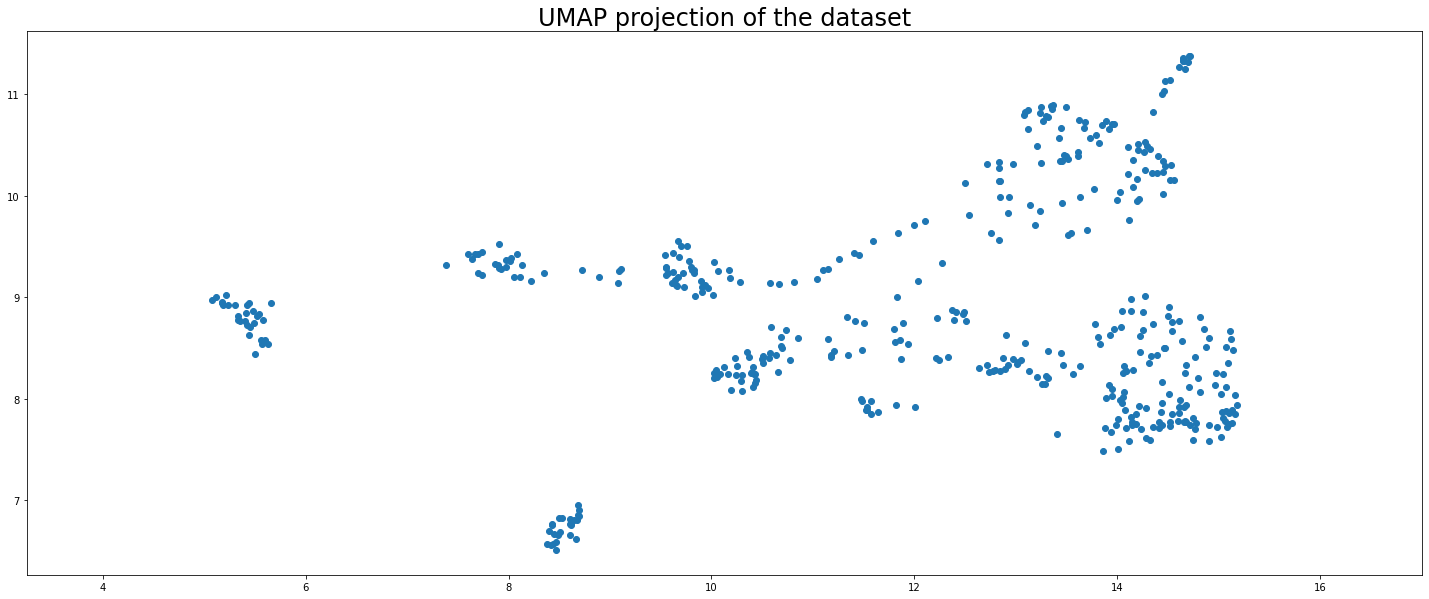

In [ ]:
print2D(featuresUMAP, "UMAP projection of the dataset")

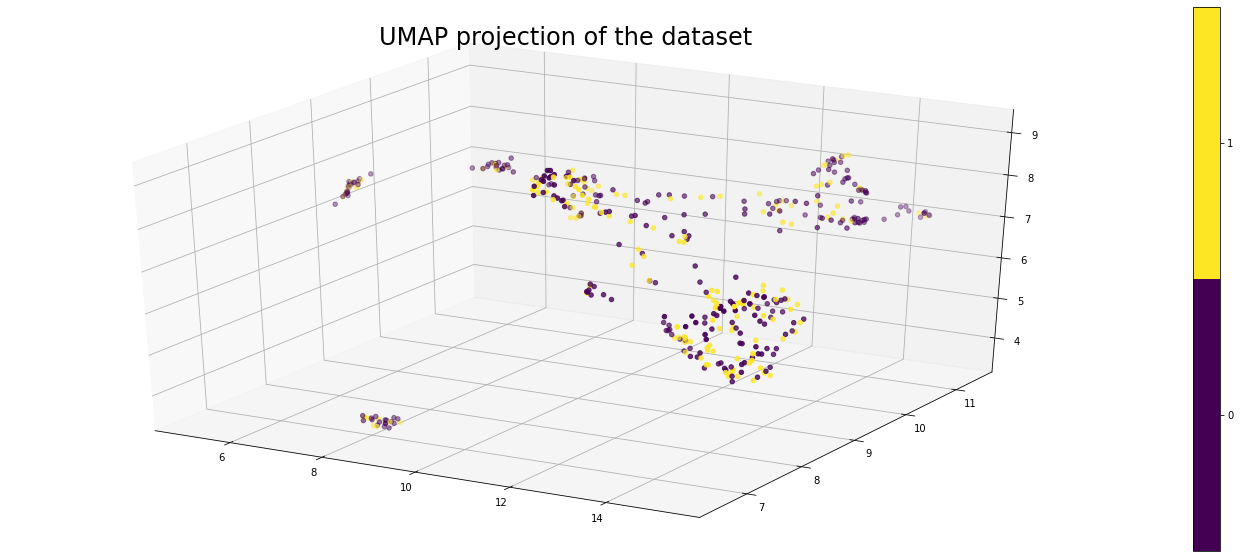

In [ ]:
print3D(featuresUMAP, "UMAP projection of the dataset", f_classes)